# Aims
In this notebook I will look at the regimes of agreement of the SES and the full 4LS (with the doubly excited state). I should expect that there will be a phonon coupling-strength and temperature dependence on this. Although there is likely to be little population in the doubly excited, it will also probably have an effect on populations. It would be good to look at dynamics and steadystate populations and coherences for the full 4LS and 3LS models.

In [3]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import heatmap_setup as hm
import numpy as np

from dimer_setup import *
from utils import *
from style import *

In [4]:
def calculate_RWA_steadystates(PARAMS, phonons, num, threshold=0.):
    ti = time.time()
    rho_rwa = []
    rho_full = []
    for alpha in phonons:
        PARAMS.update({'alpha_1':alpha, 'alpha_2': alpha})
        #energies, states = exciton_states(PARAMS)
        rwa_out = get_H_and_L(PARAMS, silent=True, threshold=threshold)
        #print(rwa_out)
        rho_rwa.append(steadystate(rwa_out['H'][1], [rwa_out['L']]))
        #rho_full.append(steadystate(rwa_out['H'][1], [rwa_out['L']]))
        #print ss.diag()
    name_save = 'DATA/SES_validity_ss/4LS_wxx{}_{}'.format(int(PARAMS['w_xx']/(10e-3*ev_to_inv_cm)), num)
    save_obj(dict({'rho_nonadd' : rho_rwa, 'phonons': phonons, 'PARAMS': rwa_out['PARAMS']}), name_save)
    print ('Calculation complete in {} seconds and saved at {}'.format(time.time() - ti, name_save))
    return rho_rwa



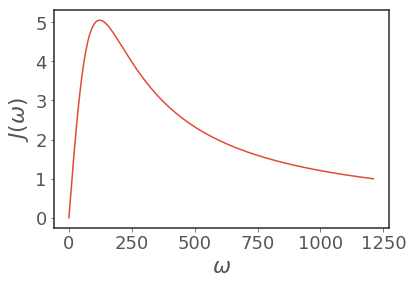

Calculation complete in 684.5811278820038 seconds and saved at DATA/SES_validity_ss/4LS_wxx0_1
Calculation complete in 931.3237900733948 seconds and saved at DATA/SES_validity_ss/4LS_wxx15_1
Calculation complete in 996.0850868225098 seconds and saved at DATA/SES_validity_ss/4LS_wxx30_1


In [5]:
# Figure 1.3 : run this with N=5
N=5
N_phonon = 35
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 0*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 15e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 5800.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3

eta = gap(bias, V)
w0 = 5*eta # 
wc = eta/2
Gamma = (w0**2)/wc
plot_UD_SD(Gamma, 10, w0, eps=5*eta)

phonons = np.linspace(1e-5, 15e-3, N_phonon)*ev_to_inv_cm

for w_xx in np.array([0., 15, 30])*10e-3*ev_to_inv_cm:
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w0, w_xx=w_xx,
                          silent=True, exc_diff=0)
    calculate_RWA_steadystates(PARAMS, phonons, 1, threshold=0.)


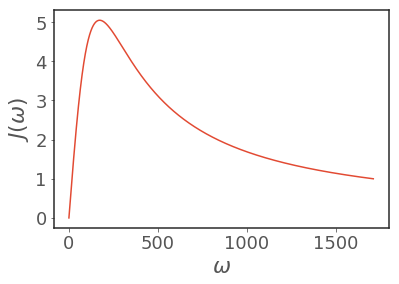

Calculation complete in 342.401052236557 seconds and saved at DATA/SES_validity_ss/4LS_wxx0_2


In [8]:
# Figure 1.3 : run this with N=5
N=5
#N_phonon = 35
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 30e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 15e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 5800.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3

eta = gap(bias, V)
w0 = 5*eta # 
wc = eta/2
Gamma = (w0**2)/wc
plot_UD_SD(Gamma, 10, w0, eps=5*eta)

#phonons = np.linspace(1e-5, 15e-3, N_phonon)*ev_to_inv_cm
phonons = np.logspace(np.log10(1e-1), np.log10(20), 20)*ev_to_inv_cm/1000.

for w_xx in np.array([0.])*10e-3*ev_to_inv_cm:
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w0, w_xx=w_xx,
                          silent=True, exc_diff=0)
    calculate_RWA_steadystates(PARAMS, phonons, 2, threshold=0.)

In [27]:
def get_dynamics_data(PARAMS, data_num, threshold=0.):
    #print PARAMS['H_sub'].eigenstates()
    rwa_out = get_H_and_L_RWA(PARAMS,silent=False, threshold=threshold)
    #add_rwa_out = get_H_and_L_add(PARAMS,silent=False, threshold=0., rwa=False)
    #add_out = get_H_and_L_add(PARAMS,silent=False, threshold=0., rwa=True)
    #print(rwa_out['L'].eigenenergies())
    evals, evecs = exciton_states(PARAMS, shift=False)
    dark, bright = evecs[0]*evecs[0].dag(), evecs[1]*evecs[1].dag()
    eig_x = (evecs[0]*evecs[1].dag() + evecs[1]*evecs[0].dag())*0.5
    ops = make_expectation_operators(PARAMS)
    site_x = (site_coherence+site_coherence.dag())
    
    # 1 is weak coupling, room temperature, low freq
    timelist = np.linspace(0, 1.9, 1900)

    init_sys = OO_proj
    v0 = tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], Occupation(PARAMS['w0_1'], PARAMS['T_1'])))
    e_ops=[ops['OO'], ops['XO'], ops['OX'],  ops['XX'], ops['sigma_x'], ops['eig_x'], ops['sigma_y'], ops['eig_y']]
    options = qt.Options(nsteps=15000)
    dat1 = qt.mesolve(rwa_out['H_RWA'][1], v0, timelist, c_ops=[rwa_out['L_RWA']], 
                      e_ops=e_ops, progress_bar=True, options=options)
    dat11 = qt.mesolve(rwa_out['H'][1], v0, timelist, c_ops=[rwa_out['L']], 
                      e_ops=e_ops, progress_bar=True, options=options)
    try:
        filename = 'DATA/DYNAMICS_2019/4LS_dynamics_'+str(data_num)
        save_obj([dat11, PARAMS], filename)
        print( "Filename: "+filename)
    except Exception as e:
        print( "Could not save data because ", e)
    return timelist, dat1, dat11

In [10]:
def plotting(timelist, dat1, dat11):
    plt.figure()
    plt.ylabel('Ground state')
    plt.plot(timelist, dat1.expect[0])
    plt.plot(timelist, dat11.expect[0])
    
    plt.figure()
    plt.ylabel('Site populations')
    plt.plot(timelist, dat1.expect[1], c='b')
    plt.plot(timelist, dat11.expect[1], c='r', ls='dotted')
    plt.plot(timelist, dat1.expect[2], c='b')
    plt.plot(timelist, dat11.expect[2], c='r', ls='dotted')

    

    plt.figure()
    plt.ylabel('Doubly excited')
    plt.plot(timelist, dat1.expect[3])
    plt.plot(timelist, dat11.expect[3])

    plt.figure()
    plt.ylabel('Site coherence')
    plt.plot(timelist, dat1.expect[4])
    plt.plot(timelist, dat11.expect[4])

In [39]:
T_ph = 300.
w_2 = 5000. #1.4*ev_to_inv_cm
bias = 100. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 100. #0.01*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 0.
alpha_EM = 0.03 #5.309e-3 # inv_ps_to_inv_cm *10^-3
N =4
wc = 53.
w_0 = 600.
Gamma = (w_0**2)/wc
T_EM = 6000.
timelist = np.linspace(0, 0.19, 5000)
#phonons = np.logspace(-1,np.log10(20),8)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, V = V, alpha=alpha,
                      T_EM=T_EM, T_ph =T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0, w_xx=bias)

#d1 = load_obj('DATA/DYNAMICS_2019/3LS_dynamics_1')
#data1, PARAMS1 = d1[0], d1[1]

data_num = 1


In [47]:
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, V = V, alpha=10.,
                      T_EM=T_EM, T_ph =T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
rwa_out = get_H_and_L_RWA(PARAMS,silent=False, threshold=0.)
print( rwa_out['PARAMS']['kappa_1'])

****************************************************************
The operators took 1.101154088973999 and have dimension 52.
Building the RC Liouvillian took 1.215 seconds.
It is 2704by2704. The full basis would be 4096by4096
****************************************************************
The operators took 1.1039459705352783 and have dimension 52.
Building the RC Liouvillian took 1.169 seconds.
It is 2704by2704. The full basis would be 4096by4096
Full optical Liouvillian took 1.5884478092193604 seconds.
It took  1.0039441585540771  seconds to build the Non-secular RWA Liouvillian
Completed non-additive liouvillians in RWA and non-RWA form
97.08129562778495


In [40]:
#PARAMS['exc'] = 10
rwa_out = get_H_and_L_RWA(PARAMS,silent=False, threshold=0.)
ss = steadystate(rwa_out['H'][1], [rwa_out['L']])
ops = make_expectation_operators(PARAMS)
ss_pops_ptrace = ENR_ptrace(ss, 0, N).diag()
ss_pops = [(ss*op).tr().real for op in [ops['OO'], ops['XO'], ops['OX'], ops['XX']]]
print( ss_pops_ptrace)
print( ss_pops)
print( thermal_state(6000., rwa_out['H'][0]).diag())
ss = steadystate(rwa_out['H_RWA'][1], [rwa_out['L_RWA']])
ops = make_expectation_operators(PARAMS)
ss_pops_ptrace = ENR_ptrace(ss, 0, N).diag()
ss_pops = [(ss*op).tr().real for op in [ops['OO'], ops['XO'], ops['OX'], ops['XX']]]
print( ss_pops_ptrace)
print( ss_pops)
print( thermal_state(6000., rwa_out['H_RWA'][0]).diag())

****************************************************************
The operators took 0.4873931407928467 and have dimension 52.
Building the RC Liouvillian took 0.500 seconds.
It is 2704by2704. The full basis would be 4096by4096
****************************************************************
The operators took 0.47130584716796875 and have dimension 52.
Building the RC Liouvillian took 0.484 seconds.
It is 2704by2704. The full basis would be 4096by4096
Full optical Liouvillian took 0.3660008907318115 seconds.
It took  0.46905088424682617  seconds to build the Non-secular RWA Liouvillian
Completed non-additive liouvillians in RWA and non-RWA form
[0.59431946 0.17492574 0.16912377 0.00951387]
[0.5943195125314402, 0.1749566107495454, 0.17920210083833685, 0.0515217758806777]
[0.59431951 0.17495661 0.1792021  0.05152178]
[0.59430784 0.17494805 0.16914535 0.00951508]
[0.594307808310817, 0.1749789397148756, 0.1792249716385797, 0.05148828033572802]
[0.59430781 0.17497894 0.17922497 0.05148828]


In [4]:
timelist, dat1, dat11 = get_dynamics_data(PARAMS, 1, threshold=0.)
plotting(timelist, dat1, dat11)

****************************************************************
The operators took 0.6313750743865967 and have dimension 52.
Building the RC Liouvillian took 0.645 seconds.
It is 2704by2704. The full basis would be 4096by4096
****************************************************************
The operators took 0.4649012088775635 and have dimension 52.
Building the RC Liouvillian took 0.477 seconds.
It is 2704by2704. The full basis would be 4096by4096
Not including optical dissipator
Completed non-additive liouvillians in RWA and non-RWA form
Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]
[8.26598754e-01 7.51313459e-02 6.82885028e-03 6.20688949e-04
 7.51313459e-02 6.82885028e-03 6.20688949e-04 5.64157590e-05
 6.82885028e-03 6.20688949e-04 5.64157590e-05 6.20688949e-04
 5.64157590e-05]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999999999999999, 0.0]
Quantum object: dims = [[4, 4, 4], [4, 4, 4]],

# Steadystate as a function of $\alpha$

In [3]:
def calculate_RWA_steadystate_comparison(PARAMS, phonons, num, threshold=0.):
    ti = time.time()
    rho_rwa = []
    rho_full = []
    for alpha in phonons:
        PARAMS.update({'alpha_1':alpha, 'alpha_2': alpha})
        #energies, states = exciton_states(PARAMS)
        rwa_out = get_H_and_L_RWA(PARAMS, silent=True, threshold=threshold)
        rho_rwa.append(steadystate(rwa_out['H_RWA'][1], [rwa_out['L_RWA']]))
        #rho_full.append(steadystate(rwa_out['H'][1], [rwa_out['L']]))
        print( alpha)
        #print ss.diag()
    name_save = 'DATA/SES_validity_ss/4ls_{}'.format(num)
    save_obj([rho_rwa, rho_full, rwa_out['PARAMS']], name_save)
    print ('Calculation complete in {} seconds and saved at {}'.format(time.time() - ti, name_save))
    return rho_rwa, rho_full

# Low $\omega_0$

In [7]:
10e-3*ev_to_inv_cm

80.655

In [8]:
phonons = np.linspace(0.5, 10e-3*ev_to_inv_cm, 50)
T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 0. #0.01*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 0.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
N =6
#wc = 50.
w_0 = 80e-3*ev_to_inv_cm
Gamma = 30e-3*ev_to_inv_cm
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)


rho_rwa1, rho_full1 = calculate_RWA_steadystate_comparison(PARAMS, phonons, 1, threshold=1e-10)

0.5
2.1358163265306125
3.7716326530612245
5.407448979591837
7.043265306122449
8.67908163265306
10.314897959183673
11.950714285714286
13.586530612244898
15.22234693877551
16.85816326530612
18.493979591836734
20.129795918367346
21.76561224489796
23.40142857142857
25.037244897959184
26.673061224489796
28.30887755102041
29.94469387755102
31.580510204081634
33.21632653061224
34.85214285714286
36.48795918367347
38.123775510204084
39.75959183673469
41.39540816326531
43.03122448979592
44.667040816326534
46.30285714285714
47.93867346938776
49.57448979591837
51.21030612244898
52.84612244897959
54.4819387755102
56.11775510204082
57.753571428571426
59.38938775510204
61.02520408163265
62.66102040816327
64.29683673469387
65.93265306122449
67.5684693877551
69.20428571428572
70.84010204081633
72.47591836734694
74.11173469387755
75.74755102040817
77.38336734693878
79.01918367346939
80.655
Calculation complete in 1905.6011002063751 seconds and saved at DATA/SES_validity_ss/4ls_1


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


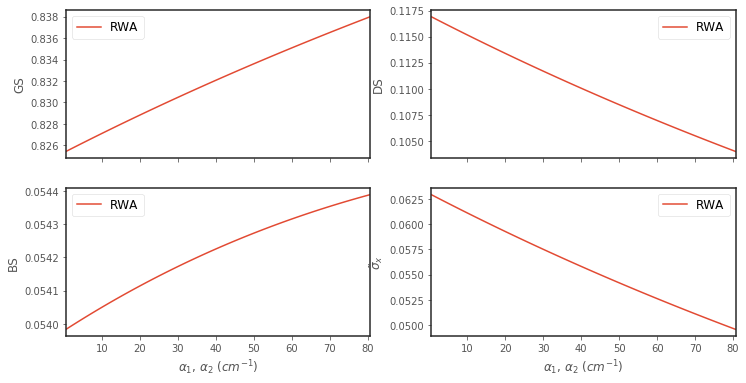

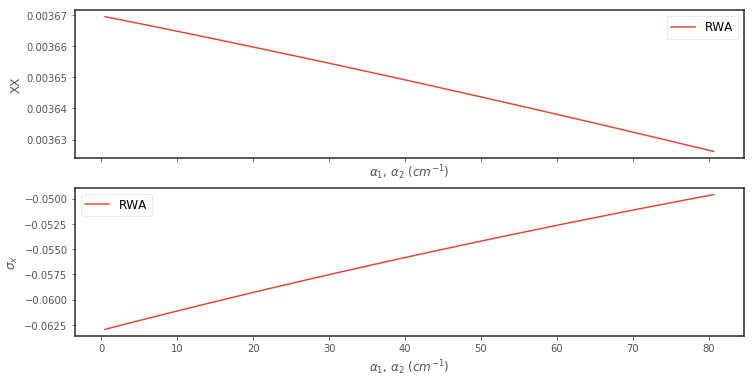

In [16]:
plotting_SS(phonons, rho_rwa1, rho_full1, PARAMS)

# larger $\omega_0$

0.5
2.5306122448979593
4.561224489795919
6.591836734693878
8.622448979591837
10.653061224489797
12.683673469387756
14.714285714285715
16.744897959183675
18.775510204081634
20.806122448979593
22.836734693877553
24.867346938775512
26.89795918367347
28.92857142857143
30.95918367346939
32.98979591836735
35.02040816326531
37.05102040816327
39.08163265306123
41.11224489795919
43.142857142857146
45.173469387755105
47.204081632653065
49.234693877551024
51.26530612244898
53.29591836734694
55.3265306122449
57.35714285714286
59.38775510204082
61.41836734693878
63.44897959183674
65.4795918367347
67.51020408163265
69.54081632653062
71.57142857142858
73.60204081632654
75.63265306122449
77.66326530612245
79.69387755102042
81.72448979591837
83.75510204081633
85.78571428571429
87.81632653061226
89.84693877551021
91.87755102040816
93.90816326530613
95.9387755102041
97.96938775510205
100.0
Calculation complete in 693.6793961524963 seconds and saved at DATA/SES_validity_ss/4ls_2


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


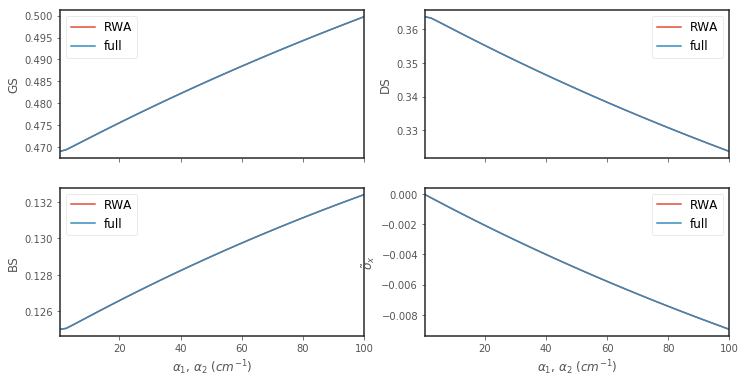

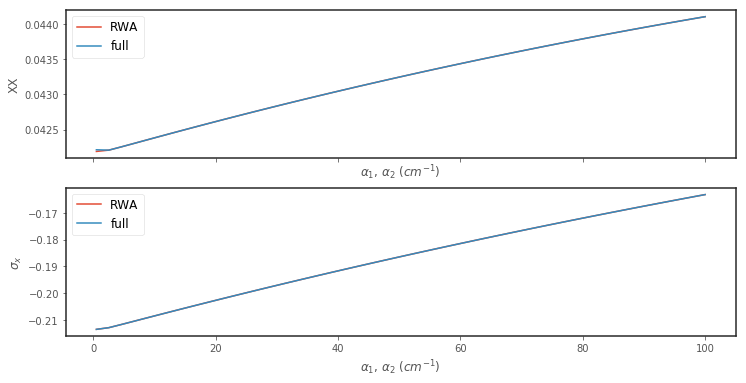

In [113]:
w_0 = 500.
Gamma = 200.
T_ph = 300.
N=5
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
rho_rwa2, rho_full2 = calculate_RWA_steadystate_comparison(PARAMS, phonons, 2, threshold=0.)
plotting_SS(phonons, rho_rwa2, rho_full2, PARAMS)

/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


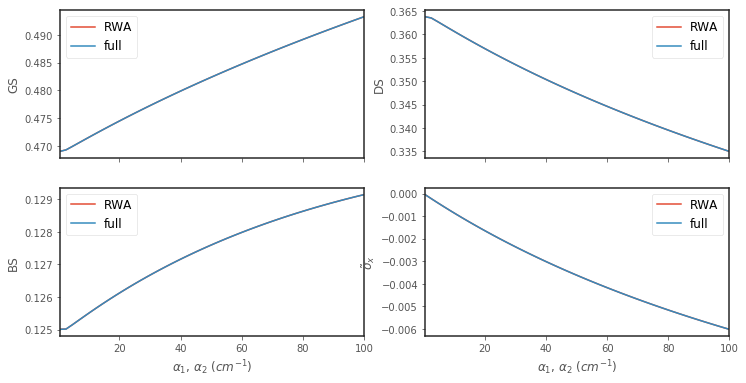

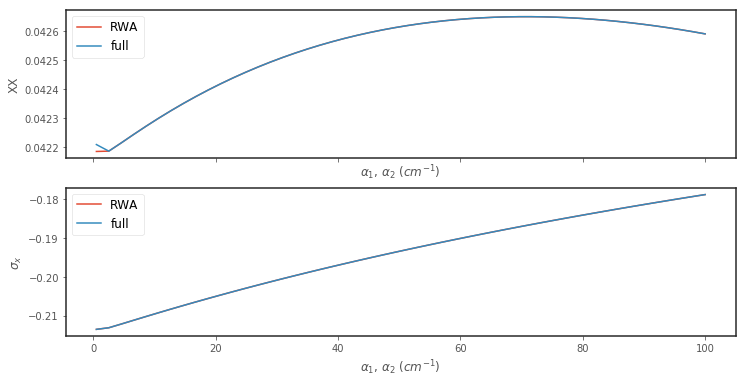

# Low $T_{ph}$

0.5
2.5306122448979593
4.561224489795919
6.591836734693878
8.622448979591837
10.653061224489797
12.683673469387756
14.714285714285715
16.744897959183675
18.775510204081634
20.806122448979593
22.836734693877553
24.867346938775512
26.89795918367347
28.92857142857143
30.95918367346939
32.98979591836735
35.02040816326531
37.05102040816327
39.08163265306123
41.11224489795919
43.142857142857146
45.173469387755105
47.204081632653065
49.234693877551024
51.26530612244898
53.29591836734694
55.3265306122449
57.35714285714286
59.38775510204082
61.41836734693878
63.44897959183674
65.4795918367347
67.51020408163265
69.54081632653062
71.57142857142858
73.60204081632654
75.63265306122449
77.66326530612245
79.69387755102042
81.72448979591837
83.75510204081633
85.78571428571429
87.81632653061226
89.84693877551021
91.87755102040816
93.90816326530613
95.9387755102041
97.96938775510205
100.0
Calculation complete in 688.8926270008087 seconds and saved at DATA/SES_validity_ss/4ls_3


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


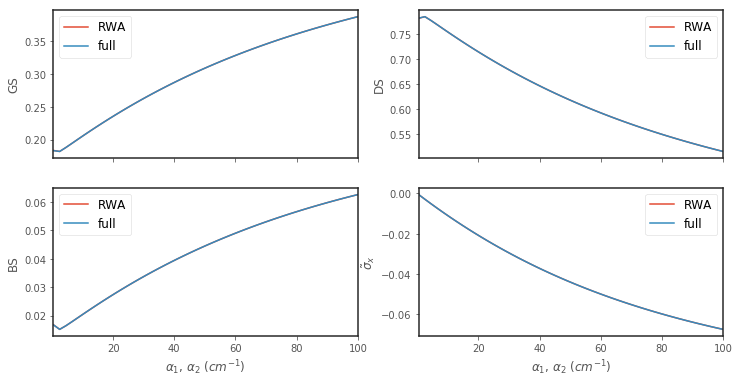

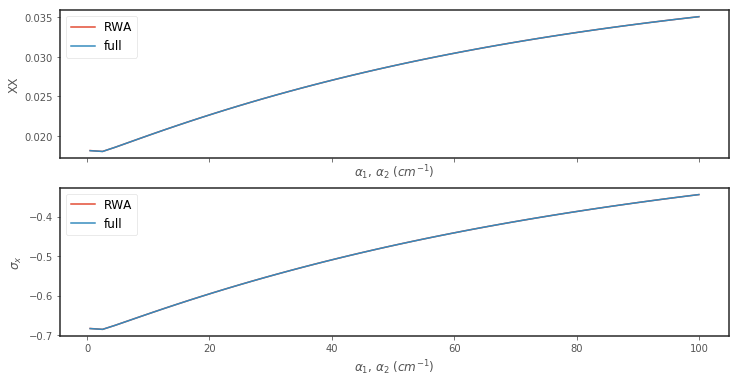

In [96]:
w_0 = 100.
Gamma = 200.
N=5
T_ph = 77.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
rho_rwa3, rho_full3 = calculate_RWA_steadystate_comparison(PARAMS, phonons, 3, threshold=1e-10)
plotting_SS(phonons, rho_rwa3, rho_full3, PARAMS)

# very high $\omega_0$ (underdamped), but not larger than site energy

0.5
2.5306122448979593
4.561224489795919
6.591836734693878
8.622448979591837
10.653061224489797
12.683673469387756
14.714285714285715
16.744897959183675
18.775510204081634
20.806122448979593
22.836734693877553
24.867346938775512
26.89795918367347
28.92857142857143
30.95918367346939
32.98979591836735
35.02040816326531
37.05102040816327
39.08163265306123
41.11224489795919
43.142857142857146
45.173469387755105
47.204081632653065
49.234693877551024
51.26530612244898
53.29591836734694
55.3265306122449
57.35714285714286
59.38775510204082
61.41836734693878
63.44897959183674
65.4795918367347
67.51020408163265
69.54081632653062
71.57142857142858
73.60204081632654
75.63265306122449
77.66326530612245
79.69387755102042
81.72448979591837
83.75510204081633
85.78571428571429
87.81632653061226
89.84693877551021
91.87755102040816
93.90816326530613
95.9387755102041
97.96938775510205
100.0
Calculation complete in 688.1997380256653 seconds and saved at DATA/SES_validity_ss/4ls_4


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


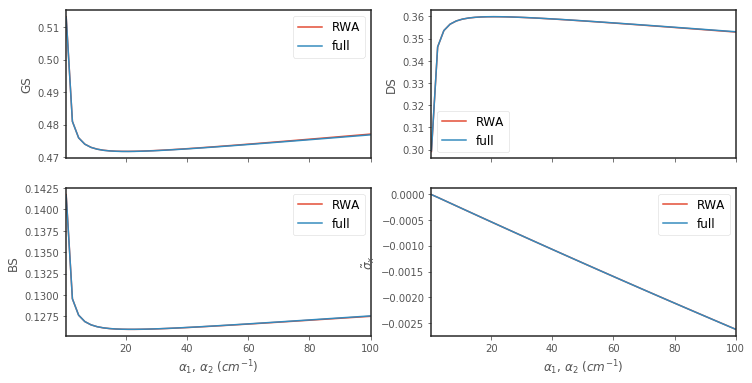

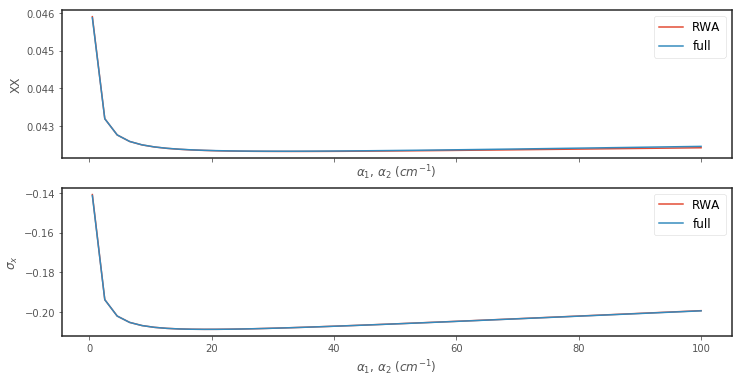

In [114]:
w_0 = 5000.
Gamma = 200.
N=5
T_ph = 300.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
rho_rwa4, rho_full4 = calculate_RWA_steadystate_comparison(PARAMS, phonons, 4, threshold=1e-10)
plotting_SS(phonons, rho_rwa4, rho_full4, PARAMS)

# very high $\omega_0$ (overdamped), but not larger than site energy

0.5
2.5306122448979593
4.561224489795919
6.591836734693878
8.622448979591837
10.653061224489797
12.683673469387756
14.714285714285715
16.744897959183675
18.775510204081634
20.806122448979593
22.836734693877553
24.867346938775512
26.89795918367347
28.92857142857143
30.95918367346939
32.98979591836735
35.02040816326531
37.05102040816327
39.08163265306123
41.11224489795919
43.142857142857146
45.173469387755105
47.204081632653065
49.234693877551024
51.26530612244898
53.29591836734694
55.3265306122449
57.35714285714286
59.38775510204082
61.41836734693878
63.44897959183674
65.4795918367347
67.51020408163265
69.54081632653062
71.57142857142858
73.60204081632654
75.63265306122449
77.66326530612245
79.69387755102042
81.72448979591837
83.75510204081633
85.78571428571429
87.81632653061226
89.84693877551021
91.87755102040816
93.90816326530613
95.9387755102041
97.96938775510205
100.0
Calculation complete in 655.3418791294098 seconds and saved at DATA/SES_validity_ss/4ls_5


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


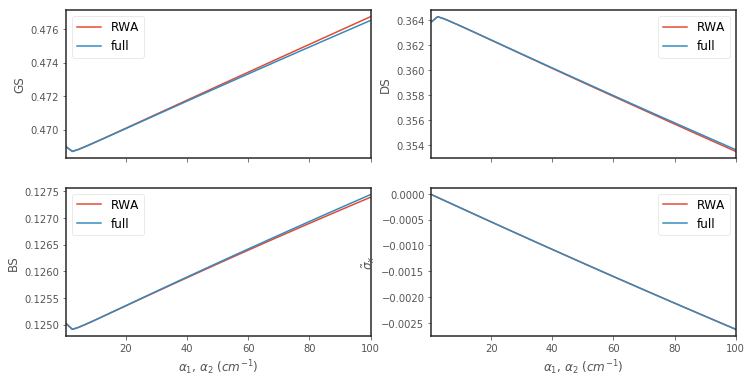

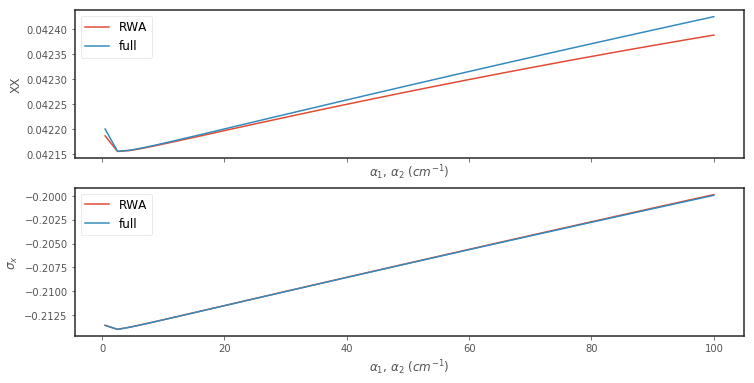

In [104]:
w_0 = 5000. # 
Gamma = (w_0**2)/53.
N=5
T_ph = 300.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
rho_rwa5, rho_full5 = calculate_RWA_steadystate_comparison(PARAMS, phonons, 5, threshold=0.)
plotting_SS(phonons, rho_rwa5, rho_full5, PARAMS)

# very high $\omega_0$ (underdamped), LARGER than site energies

0.5
2.5306122448979593
4.561224489795919
6.591836734693878
8.622448979591837
10.653061224489797
12.683673469387756
14.714285714285715
16.744897959183675
18.775510204081634
20.806122448979593
22.836734693877553
24.867346938775512
26.89795918367347
28.92857142857143
30.95918367346939
32.98979591836735
35.02040816326531
37.05102040816327
39.08163265306123
41.11224489795919
43.142857142857146
45.173469387755105
47.204081632653065
49.234693877551024
51.26530612244898
53.29591836734694
55.3265306122449
57.35714285714286
59.38775510204082
61.41836734693878
63.44897959183674
65.4795918367347
67.51020408163265
69.54081632653062
71.57142857142858
73.60204081632654
75.63265306122449
77.66326530612245
79.69387755102042
81.72448979591837
83.75510204081633
85.78571428571429
87.81632653061226
89.84693877551021
91.87755102040816
93.90816326530613
95.9387755102041
97.96938775510205
100.0
Calculation complete in 867.5709331035614 seconds and saved at DATA/SES_validity_ss/4ls_6


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


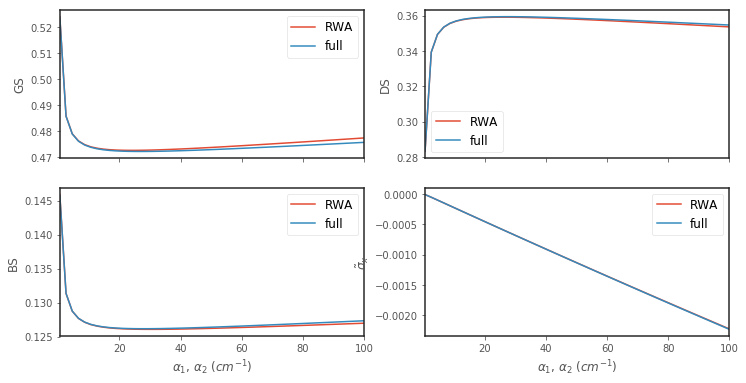

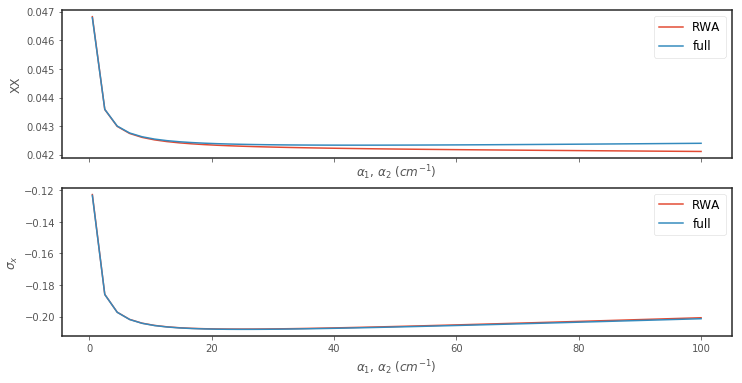

In [109]:
w_0 = 6000. # 
Gamma = 200.
N=5
T_ph = 300.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
rho_rwa6, rho_full6 = calculate_RWA_steadystate_comparison(PARAMS, phonons, 6, threshold=0.)
plotting_SS(phonons, rho_rwa6, rho_full6, PARAMS)

# very high $\omega_0$ (overdamped), LARGER than site energies

Here we can see that the RWA really breaks down for the doubly excited state

0.5
2.5306122448979593
4.561224489795919
6.591836734693878
8.622448979591837
10.653061224489797
12.683673469387756
14.714285714285715
16.744897959183675
18.775510204081634
20.806122448979593
22.836734693877553
24.867346938775512
26.89795918367347
28.92857142857143
30.95918367346939
32.98979591836735
35.02040816326531
37.05102040816327
39.08163265306123
41.11224489795919
43.142857142857146
45.173469387755105
47.204081632653065
49.234693877551024
51.26530612244898
53.29591836734694
55.3265306122449
57.35714285714286
59.38775510204082
61.41836734693878
63.44897959183674
65.4795918367347
67.51020408163265
69.54081632653062
71.57142857142858
73.60204081632654
75.63265306122449
77.66326530612245
79.69387755102042
81.72448979591837
83.75510204081633
85.78571428571429
87.81632653061226
89.84693877551021
91.87755102040816
93.90816326530613
95.9387755102041
97.96938775510205
100.0
Calculation complete in 603.9537031650543 seconds and saved at DATA/SES_validity_ss/4ls_7


/Users/admin/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


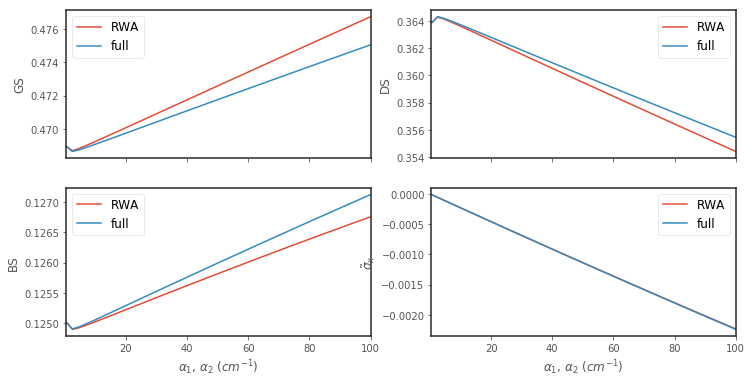

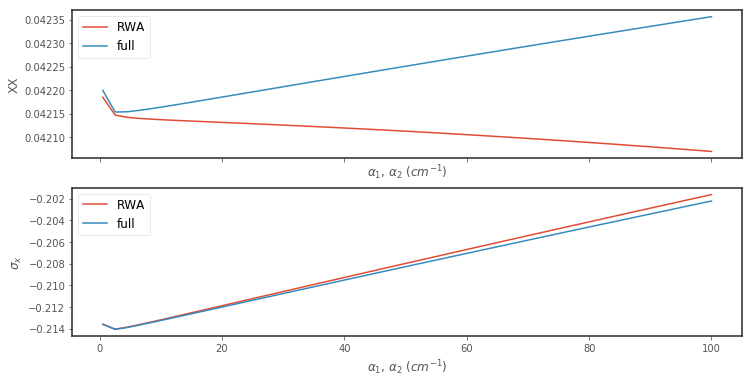

In [107]:
w_0 = 6000. # 
Gamma = (w_0**2)/53.
N=5
T_ph = 300.
PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                      silent=True, exc_diff=0)
rho_rwa7, rho_full7 = calculate_RWA_steadystate_comparison(PARAMS, phonons, 7, threshold=0.)
plotting_SS(phonons, rho_rwa7, rho_full7, PARAMS)

In [15]:
def plotting_SS(phonons, rho_rwa, rho_full, _PARAMS):
    ops = make_expectation_operators(_PARAMS)

    f, ((ax1, ax2),(ax3, ax4))  = plt.subplots(2, 2, sharex=True, figsize=(12,6))

    ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_rwa], label='RWA')
    #ax1.plot(phonons, [(r*ops['OO']).tr() for r in rho_full], label='full')
    #plt.xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
    ax1.set_ylabel(r"GS")
    ax1.set_xlim(phonons[0], phonons[-1])
    ax1.legend()

    ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_rwa], label='RWA')
    #ax2.plot(phonons, [(r*ops['dark']).tr() for r in rho_full], label='full')
    #ax2.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
    ax2.set_ylabel(r"DS")
    ax2.legend()


    ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_rwa], label='RWA')
    #ax3.plot(phonons, [(r*ops['bright']).tr() for r in rho_full], label='full')
    ax3.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
    ax3.set_ylabel(r"BS")
    ax3.legend()
    
    coherence = np.array([(r*ops['sigma_x']).tr() for r in rho_rwa])**2 
    coherence += np.array([(r*ops['sigma_y']).tr() for r in rho_rwa])**2
    coherence = np.sqrt(coherence)
    ax4.plot(phonons, coherence, label='RWA')
    #ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_rwa], label='RWA')
    #ax4.plot(phonons, [(r*ops['eig_x']).tr() for r in rho_full], label='full')
    ax4.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
    ax4.set_ylabel(r"$\tilde{\sigma}_x$")
    ax4.legend()
    plt.show()

    f, (ax5, ax6)  = plt.subplots(2, 1, sharex=True, figsize=(12,6))
    ax5.plot(phonons, [(r*ops['XX']).tr() for r in rho_rwa], label='RWA')
    #ax5.plot(phonons, [(r*ops['XX']).tr() for r in rho_full], label='full')
    ax5.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
    ax5.set_ylabel(r"XX")
    ax5.legend()

    ax6.plot(phonons, [(r*ops['sigma_x']).tr() for r in rho_rwa], label='RWA')
    #ax6.plot(phonons, [(r*ops['sigma_x']).tr() for r in rho_full], label='full')
    ax6.set_xlabel(r"$\alpha_1$, $\alpha_2$ $(cm^{-1})$")
    ax6.set_ylabel(r"$\sigma_x$")
    ax6.legend()
    plt.show()
    
